# Predicting the revenue of the movies based on vote average, budget, popularity, and runtime.

### Introduction

The entertainment industry has always been a profitable field, especially movies. However, with great profit comes great investment. Most modern-day movies require a budget of around 100 million dollars(1). It is crucial for investors/directors to understand the audience’s needs and study market demands. Thus, this project centers around studying the profitability of a movie before it is released, predicting revenues based on several predictors (vote average, budget, popularity, runtime). In this project, regression will take place to better understand/predict the relationship between revenues and different predictors.

The question we will try to answer with our project is what is the revenue of a movie based on vote average, budget, popularity, and runtime. The data set, which consists of 5000 movies from TMDB, will be separated into training and testing sets. Using other predictors (vote average, budget, popularity, runtime), the prediction of test set revenue will be made. 

In the data set “TMDB 5000 Movie Dataset”, revenues, vote average, budget, popularity, runtime are recorded for the 5000 movies listed in an excel format. Other columns are listed/included in the data set as well, however because they are written in json and not a significant predictor to the revenue, those columns will be filtered out. Revenues is defined as the total box income of the movie; vote average is defined as the ratings of the movie, budget is defined as the funding used for the production; Popularity numbers are built according to the TMDB model which consists of number of votes for the day, number of views for the day, number of users who marked it as a "favourite" for the day, Number of users who added it to their "watchlist" for the day, release date, number of total votes, and previous days score.


### Methods & Results::

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# Getting Dataset from Web
url <- "https://raw.githubusercontent.com/rehan13/DSCI-100-Project-Group25/master/tmdb_5000_movies.csv"
download.file(url, destfile = "Revenue.csv")


In [3]:
# Raw data being read from the web
Revenue_data <- read_csv("Revenue.csv")

# Exploratory Data
Revenue_Data_Particulars <- select(Revenue_data, vote_average, budget, runtime, popularity, revenue)%>%
                            filter(revenue > 10000000)%>%
                            filter(budget > 10000000)
                            
Revenue_Data_Particulars

Parsed with column specification:
cols(
  .default = col_character(),
  budget = col_double(),
  id = col_double(),
  popularity = col_double(),
  release_date = col_date(format = ""),
  revenue = col_double(),
  runtime = col_double(),
  vote_average = col_double(),
  vote_count = col_double()
)

See spec(...) for full column specifications.



vote_average,budget,runtime,popularity,revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.2,2.37e+08,162,150.4376,2787965087
6.9,3.00e+08,169,139.0826,961000000
6.3,2.45e+08,148,107.3768,880674609
⋮,⋮,⋮,⋮,⋮
7.2,1.5e+07,135,30.19604,13060843
5.9,1.6e+07,93,9.18885,68411275
5.8,3.5e+07,99,38.10049,170000000


In [4]:
# Train / Test Data
revenue_split <- initial_split(Revenue_Data_Particulars, prop = 0.50, strata = revenue)
revenue_train <- training(revenue_split)
revenue_test <- testing(revenue_split)

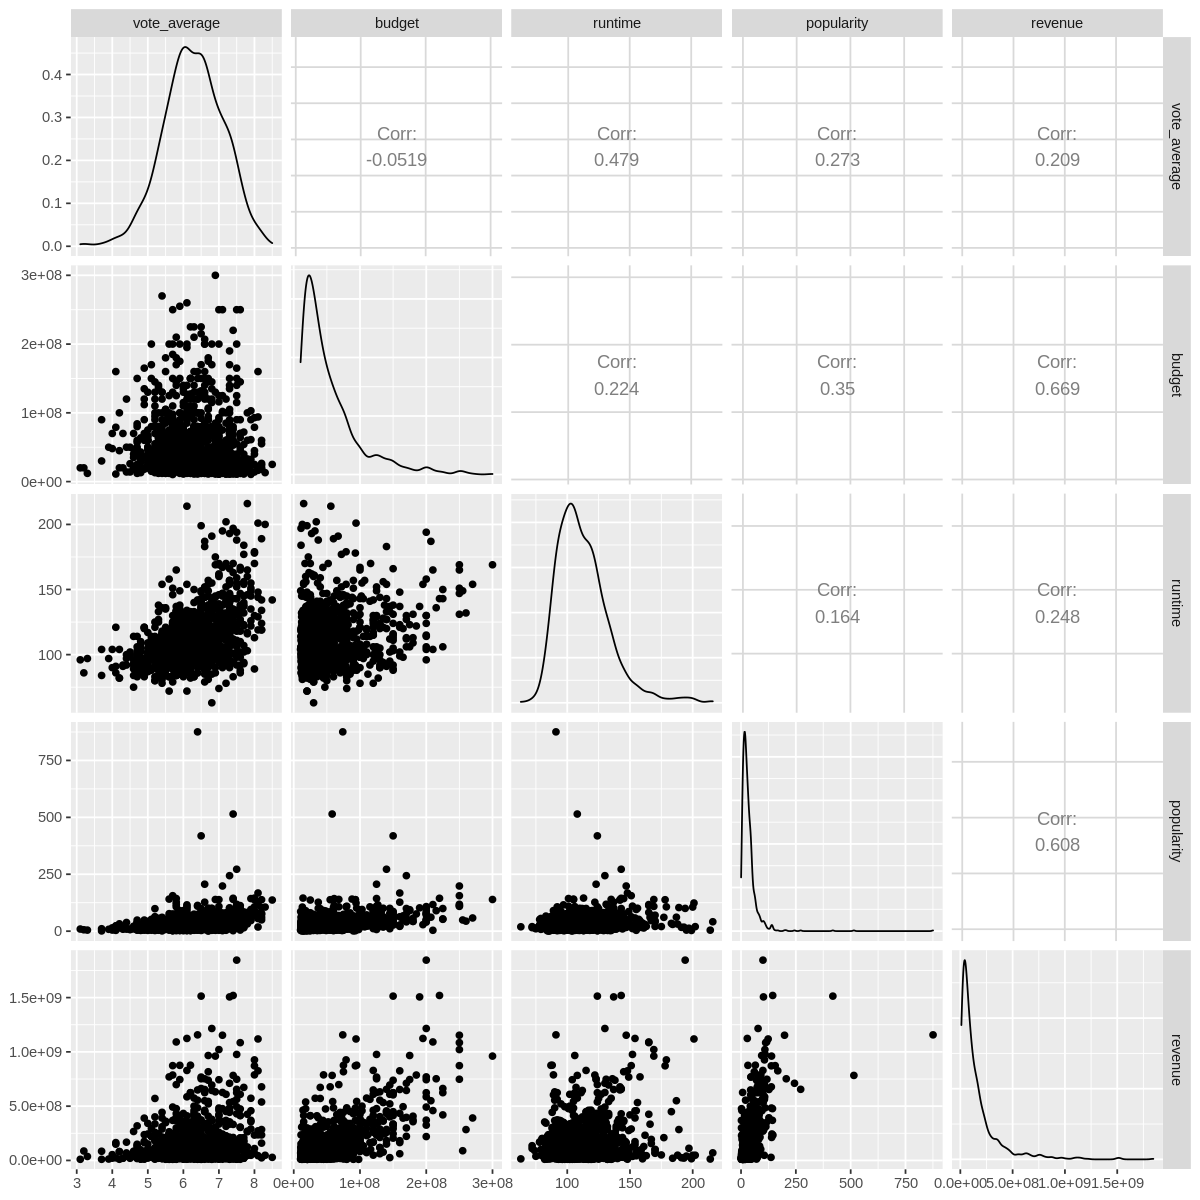

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10)
relationship_revenue <- ggpairs(revenue_train)
relationship_revenue 

In [6]:
# create recipe
revenue_recipe <- recipe(revenue ~ budget, data = revenue_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

# create KNN model
revenue_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")


In [7]:
# 5 fold cross-validation 
revenue_vfold <- vfold_cv(revenue_train, v = 5, strata = revenue)

# fitting the data in knn model
revenue_wkflw <- workflow() %>%
  add_recipe(revenue_recipe) %>%
  add_model(revenue_spec)

revenue_wkflw

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [8]:
# Setting the gridvals.
gridvals <- tibble(neighbors = seq(from = 1, to = 500, by = 2))

# results of the model.
revenue_results <- revenue_wkflw %>%
  tune_grid(resamples = revenue_vfold, grid = gridvals) %>%
  collect_metrics() %>%
  filter(.metric == "rmse")

revenue_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,239221177,5,7690966,Model001
3,rmse,standard,173937692,5,8653159,Model002
5,rmse,standard,166629831,5,10282507,Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
495,rmse,standard,179142174,5,17348022,Model248
497,rmse,standard,179260700,5,17345119,Model249
499,rmse,standard,179376388,5,17335911,Model250


In [9]:

revenue_min <- revenue_results %>%
  filter(mean == min(mean))

revenue_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
29,rmse,standard,148061276,5,13033186,Model015


In [10]:
k_min <- revenue_min %>%
        pull(neighbors)

revenue_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
         set_engine("kknn") %>%
         set_mode("regression")

revenue_best_fit <- workflow() %>%
         add_recipe(revenue_recipe) %>%
         add_model(revenue_best_spec) %>%
         fit(data = revenue_train)

revenue_summary <- revenue_best_fit %>%
          predict(revenue_test) %>%
          bind_cols(revenue_test) %>%
          metrics(truth = revenue, estimate = .pred)
revenue_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.577935e+08
rsq,standard,4.519744e-01
mae,standard,1.005952e+08


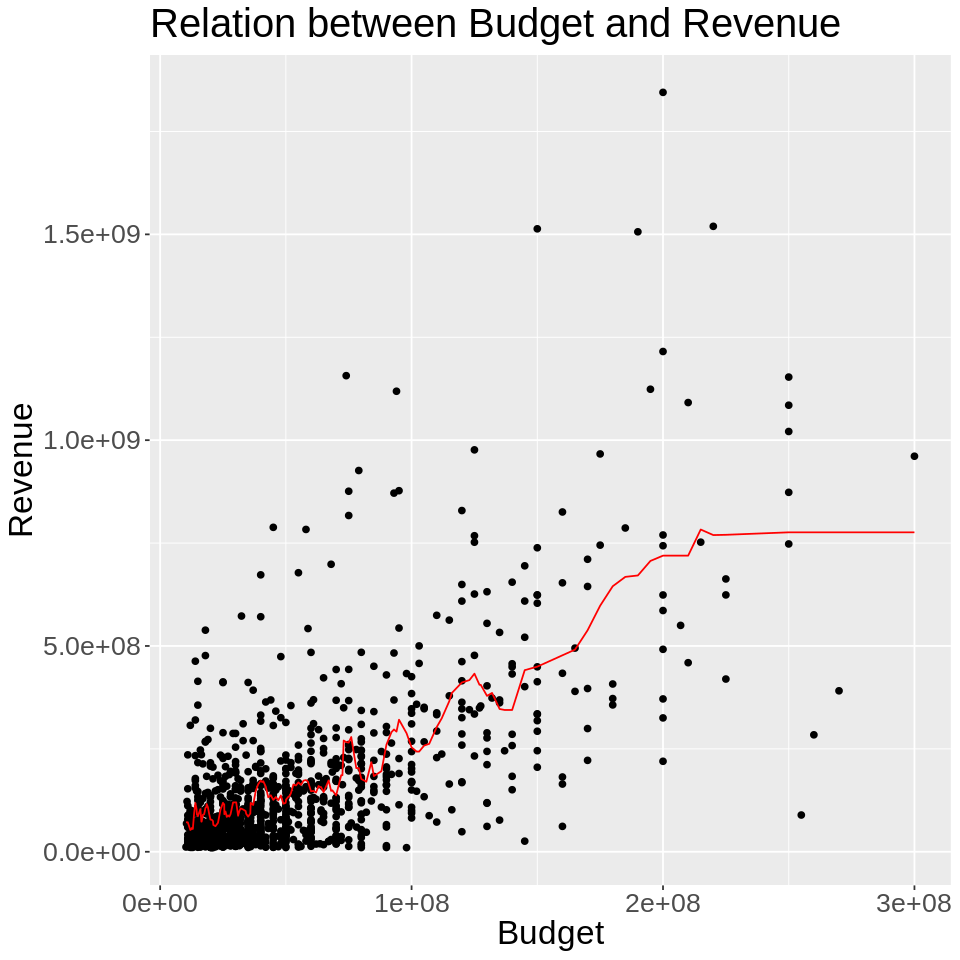

In [11]:
options(repr.plot.width = 8, repr.plot.height = 8)

# your code here
revenue_preds <- revenue_best_fit %>%
                  predict(revenue_train)%>%
                  bind_cols(revenue_train)


revenue_Budget_plot <- ggplot(revenue_preds, aes(x = budget, y = revenue)) +
                geom_point() +
                geom_line (data = revenue_preds, mapping = aes (x = budget, y = .pred), color = "red")+
                xlab ("Budget")+
                ylab("Revenue")+
                ggtitle("Relation between Budget and Revenue")+
                theme(text = element_text(size = 20))
                 
revenue_Budget_plot

### Methods:

Explain: 
This project centers around studying the profitability of a movie before it is released, predicting revenues based on several predictors (vote average, budget, popularity, runtime). In this project, regression will take place to better understand/predict the relationship between revenues and different predictors.

Since we are predicting the revenue of the movies based on vote average, budget, popularity, and runtime, the variable and columns we are using is revenues, vote average, budget, popularity, and runtime.
Use filter function to filter out the columns other than revenues, vote average, budget, popularity, and runtime.
Use graph to find the relationship between revenue and  vote average, budget, popularity, and runtime separately.
Use ggplot to graph each concepts with different shapes and colors.

Visualization: 
Take the relationship between the revenue and vote average as example.
We put the revenue on the x axis and put the vote average on the y axis. Use ggplot to make them on the graph with different colors and shapes. Label x axis as the revenue of the movie, and label y axis as The vote average of the movie. Make the graph in appropriate x and y scale.



### Expected outcomes and significance:

 We want  to find the profitability of the movie before it is released, and predict the revenue of the movie by some factors. Before a movie is  released, it will go through four or five rounds of test screenings, track the audience’s viewing behavior, and test the audience’s response questionnaires. If the statistical results in the first test screenings are not satisfactory, the director will make corresponding modifications in order to pass the second round of testing. Through data research, we can predict the box office of the movie, and we can adjust the movie to maximize profits and ask if the “big” data of movies have significance?

### Citation

Mueller, Annie. “Why Movies Cost so Much to Make.” Investopedia, Investopedia, 1 Dec. 2021, https://www.investopedia.com/financial-edge/0611/why-movies-cost-so-much-to-make.aspx#:~:text=Movie%20budgets%20can%20average%20around,and%20special%20effects%2C%20and%20marketing. 